# Fiabilité et propagation d'incertitude - BE 2

# 0) Import des bibliothèques Python

In [1]:
# pip install openturns

In [2]:
import numpy as np
import scipy as sci
import openturns as ot
import scipy.stats as stat
import scipy.optimize as opt
import time as t #utile pour mesurer le temps d'execution des fonctions
import matplotlib.pyplot as plt
%matplotlib inline

# 1) Description du problème
## 1-1) Introduction

On souhaite étudier la fiabilité d'une passerelle soumise à un chargement réparti sur son tablier. Pour cela, la passerelle est modélisée par une poutre de longueur $L$, encastrée à son extrémité gauche et en appui simple à son extrémité droite, le chargement est noté $Q(l)$. La passerelle est de section rectangulaire de base $b$ et de hauteur $h$. Le module d'élasticité du matériau servant à la construction de la passerelle est $E$. La défaillance est caractérisée par un déplacement maximal autorisé noté $u_{max}$. 

La résolution de l'équation de la statique permettant de trouver le déplacement de la passerelle est effectuée par la méthode des éléments finis.


## 1-2) Résolution par la méthode des éléments finis

Le nombre d'éléments est noté $n_{elem}$. On suppose que le chargement réparti est vertical et compte $n_{nodes}=n_{elem}+1$ composantes notées $Q_i,~i=1,\cdots,n_{nodes}$. Le code suivant crée la fonction Python qui résout l'équation de la statique par la méthode des éléments finis et renvoie le déplacement max de la structure. Pour cela $n_{elem}$ éléments de poutre à 2 degrés de liberté par noeud sont utilisés.

In [3]:
def u_structure(n_elem,L,E,I,Q):
    
        #matrice de rigidité totale
        K = np.zeros((2*(n_elem+1),2*(n_elem+1)))
        #Longeur des éléments
        l = L/n_elem
        #boucle sur les éléments
        for i in range(n_elem):
            #matrice élémentaire
            K_elem = E*I/l**3*np.array([[12.0,6.0*l,-12.0,6.0*l],\
                                        [6.0*l,4.0*l**2,-6.0*l,2.0*l**2],\
                                       [-12.0,-6.0*l,12.0,-6.0*l],\
                                       [6*l,2.0*l**2,-6.0*l,4.0*l**2]])
            #Assemblage
            K[2*i:2*(i+1),2*i:2*(i+1)] = K[2*i:2*(i+1),2*i:2*(i+1)] + K_elem[0:2,0:2]
            K[2*(i+1):2*(i+2),2*i:2*(i+1)] = K[2*(i+1):2*(i+2),2*i:2*(i+1)] + K_elem[2:4,0:2]
            K[2*i:2*(i+1),2*(i+1):2*(i+2)] = K[2*i:2*(i+1),2*(i+1):2*(i+2)] + K_elem[0:2,2:4]
            K[2*(i+1):2*(i+2),2*(i+1):2*(i+2)] = K[2*(i+1):2*(i+2),2*(i+1):2*(i+2)] + K_elem[2:4,2:4]
            #conditions aux limites
        #encastrement en l = 0
        K[0:2,:] = 0.0
        K[:,0:2] = 0.0
        K[0,0] = 1.0
        K[1,1] = 1.0
        #appui simple en l = L
        K[-2,:] = 0.0
        K[:,-2] = 0.0
        K[-2,-2] = 1.0
        #Decomposition de Cholesky
        K_fact = sci.linalg.cho_factor(K)
        #Second membre
        F = np.zeros((2*(n_elem+1),))
        F[0:-1:2] = Q    
        F[0:2] = 0.0
        F[-2] = 0.0
        #resolution du système KU = F
        U = sci.linalg.cho_solve(K_fact,F)    
        return U

def interpolation_EF(X,U,L):
    n_elem = len(U)/2-1
    l = L/n_elem
    U_X = np.zeros(X.shape)
    i = 0
    for x in X:
        #on cherche à quel élément appartient x et quelle est sa position relative
        n = np.int((x-1e-12)/l) #on se décale très légèrement sur la gauche 
        #pour ne pas avoir de problème en x=L qui donnerait n=en_elem +1 et qui poserait problème
        s = (x-(n*l))/l
        #On recupère U_i et U_j correspondant
        u_i = U[2*n]
        theta_i = U[2*n+1]
        u_j = U[2*(n+1)]
        theta_j = U[2*(n+1)+1]
        u_x = u_i*(1.0-3.0*s**2+2.0*s**3)+u_j*(3.0*s**2-2.0*s**3)\
        +theta_i*(l*(s-2.0*s**2+s**3))+theta_j*(l*(-s**2+s**3))
        U_X[i] = u_x
        i = i+1   
    return U_X    

def find_max_dep(n_elem,L,E,I,Q):
    #On commence par résoudre le problème discrétisé
    U = u_structure(n_elem,L,E,I,Q)
    #Puis on cherche le min du problème continu grace à la fonction d'interpolation
    res_opt = opt.minimize(interpolation_EF,np.array([L/2.0]),method = "SLSQP", bounds=[[0.0,L]],args=(U,L),tol=1e-12)
    u_max = res_opt['fun']
    l_max = res_opt['x']
    return l_max,u_max,U    

Dans la suite on fixera $L=10.0$, $b=1.0$, $h=0.1$, $E =12e^9$, $Q_{total} = -3000$.

Le code suivant permet de tester le code éléments finis définis à l'aide des 3 fonctions Python ci-dessus.

Question 1) : Expliquer chacune des 3 fonctions. Faire varier le nombre d'éléménts et observer l'influence sur les résultats.

le déplacement max est 0.016234240164532614 m
il est atteint en l= [5.78389485] m
la résolution du problème a duré  0.0012938976287841797 s
la résolution du problème + problème d'optimisation a duré 0.0024979114532470703 s


/tmp/ipykernel_66941/1518619603.py:47: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n = np.int((x-1e-12)/l) #on se décale très légèrement sur la gauche


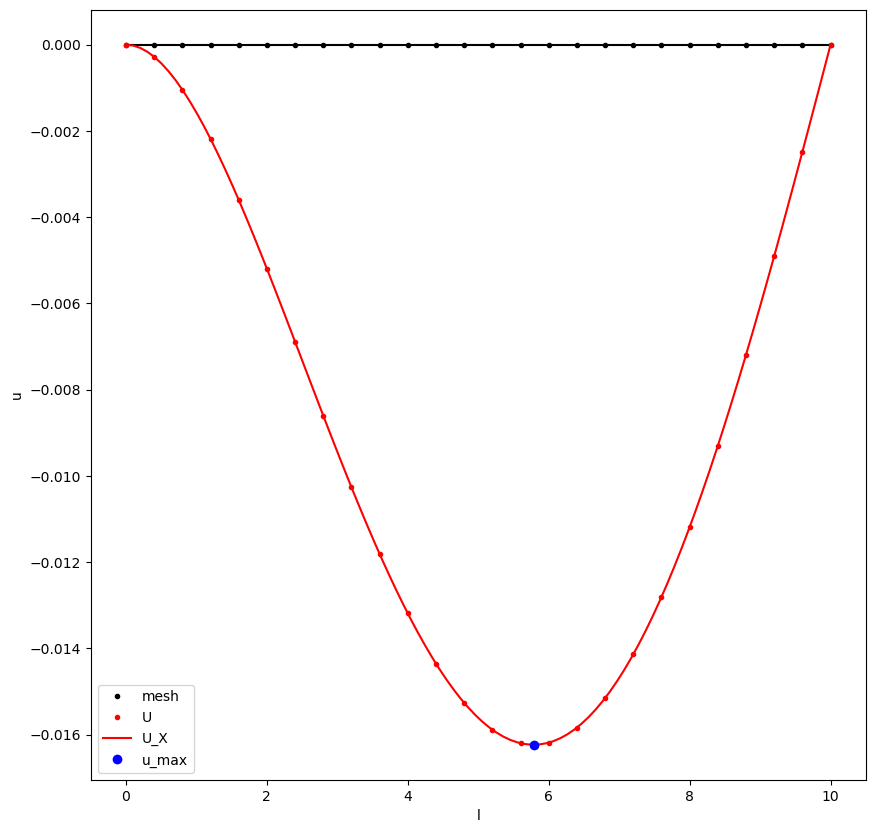

In [4]:
n_elem = 25
n_nodes = n_elem + 1
#Paramètres géométriques
L = 10.0 #longueur en métre
b = 1.0 #base de la section en métre
h = 0.1 #hauteur de la section en métre
I = b*h**3/12.0
#Paramètre matériaux
E = 12e9 #Module d'young en Pascal N/m^2
#Chargement : 
#Chargement total
Q_total = -3000.0 #Newton
#Le chargement est réparti uniformement sur les noeuds entre les 2 extremitées
Q_elem = Q_total/n_elem
Q = np.ones((n_nodes,))*Q_elem
#Résolution du problème
t1 = t.time()
U = u_structure(n_elem,L,E,I,Q)
t2 = t.time()
#Résolution + recherche du minimum
t3 = t.time()
l_max,u_max,U = find_max_dep(n_elem,L,E,I,Q)
t4 = t.time()
#interpolation de la solution EF pour le graphique
X = np.linspace(0.0,L,100)
U_X = interpolation_EF(X,U,L)
#Représentation graphique
mesh = np.linspace(0,L,n_elem+1)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(mesh,np.zeros(mesh.shape),'k.',label='mesh')
ax.plot([0.0,L],[0.0,0.0],'k')
ax.plot(mesh,U[0:-1:2],'r.',label = 'U')
ax.plot(X,U_X,'r',label ='U_X')
ax.plot(l_max,u_max,'bo',label='u_max')
ax.set_xlabel('l')
ax.set_ylabel('u')
ax.legend(loc=0)

#Affichage des résultats
print ("le déplacement max est", abs(u_max) ,"m")
print ("il est atteint en l=",l_max, "m")
print ("la résolution du problème a duré ", (t2-t1), 's')
print ("la résolution du problème + problème d'optimisation a duré", (t4-t3), 's')

<p class="bg-primary" style="padding:1em">**Question 2 :** Compléter le code suivant qui permet de tracer la courbe $u_{max} = f(n_{elem})$ pour $n_{elem}$ qui varie entre 3 et 50, quelle phénomène est illustré? En déduire le nombre minimal d'éléments à utiliser pour la simulation.</p> 

In [5]:
N_elem = np.arange(3,50,1) 
#Paramètres géométriques
L = 10.0 #longueur en métre
b = 1.0 #base de la section en métre
h = 0.1 #hauteur de la section en métre
I = b*h**3/12.0
#Paramètre matériaux
E = 12e9 #Module d'young en Pascal N/m^2
#Chargement : 
#Chargement total
Q_total = -3000.0 #Newton
#Liste pour stocker les résultats
U_max = []
for n_elem in N_elem:
    n_elem = int(n_elem)
    n_nodes = n_elem + 1
    #Le chargement est réparti uniformement sur les noeuds entre les 2 extremitées
    Q_elem = Q_total/n_elem
    Q = np.ones((n_nodes,))*Q_elem
    #Résolution du problème
    l_max,u_max,U = find_max_dep(n_elem,L,E,I,Q)
    U_max.append(u_max)

/tmp/ipykernel_66941/1518619603.py:47: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n = np.int((x-1e-12)/l) #on se décale très légèrement sur la gauche


# 2) Propagation d'incertitude et fiabilité

On suppose à présent que les variables $b$ et $E$ sont aléatoires. L'objectif est de modéliser ces variables incertaines et de résoudre un problème de fiabilité par les méthode de Monte Carlo, FORM et tirage d'importance. 

## 2-1) Modèle probabiliste des variables $b$ et $E$

Dans la suite on suppose que le code EF ci dessus donne la **valeur exacte** du déplacement maximal de la passerelle.
Dans cet exercice nous allons considérer que les paramètres $E$ et $b$ sont des variables aléatoires indépendantes telles que :
- $E$ suit une loi log-normale de moyenne $\mu_E=12e9$ et de coefficient de variation $10\%$ http://openturns.github.io/openturns/latest/user_manual/_generated/openturns.LogNormal.html?highlight=lognormal. Remarque : $X$ de loi log-normale, $\mu_X= E[X]$, $\sigma_X=\sqrt{Var[X]}$, il existe une unique variable $Y$ de loi normale telle que $ln(X) = Y$ de moyenne $\mu_Y=\lambda_X$ et d'ecart type $\sigma_Y=\xi_X$ et nous avons
$$
\lambda_X = ln\left( \frac{\mu_X}{\sqrt{1+(\frac{\sigma_X}{\mu_X})^2}}\right)
$$
$$
\xi_X = \sqrt{ ln(1+(\frac{\sigma_X}{\mu_X})^2)}
$$

- $b$ suit une loi uniforme sur $[0.9,1.1]$ http://openturns.github.io/openturns/latest/user_manual/_generated/openturns.Uniform.html?highlight=uniform




<p class="bg-primary" style="padding:1em"> **Question 2) :** Compléter le code ci dessous afin de définir le modèle probabiliste des variables $E$ et $b$.</p>

In [6]:
mean_E = 12e9
cv_E = 0.1
Lambda_E = np.log(mean_E/(np.sqrt(1.+cv_E**2)))
Xi_E = np.sqrt(np.log(1.+cv_E**2))
Loi_E = ot.LogNormal(Lambda_E,Xi_E)
print ("mu_E =",Loi_E.getMean()[0],", cv_E=", Loi_E.getStandardDeviation()[0]/Loi_E.getMean()[0])
b_inf = 0.9
b_sup = 1.1
Loi_b = ot.Uniform(0.9,1.1)
print ("mu_b=",Loi_b.getMean()[0],", cv_b=", Loi_b.getStandardDeviation()[0]/Loi_b.getMean()[0])

mu_E = 12000000000.000008 , cv_E= 0.1000000000000002
mu_b= 1.0 , cv_b= 0.0577350269189626


Une fois la loi de probabilité des paramètres aléatoires créée, nous allons générer des échantillons suivant cette loi de probabilité. Le code suivant génère 3 échantillons, exécute le code éléments finis et trace les résultats.


/tmp/ipykernel_66941/1518619603.py:47: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n = np.int((x-1e-12)/l) #on se décale très légèrement sur la gauche


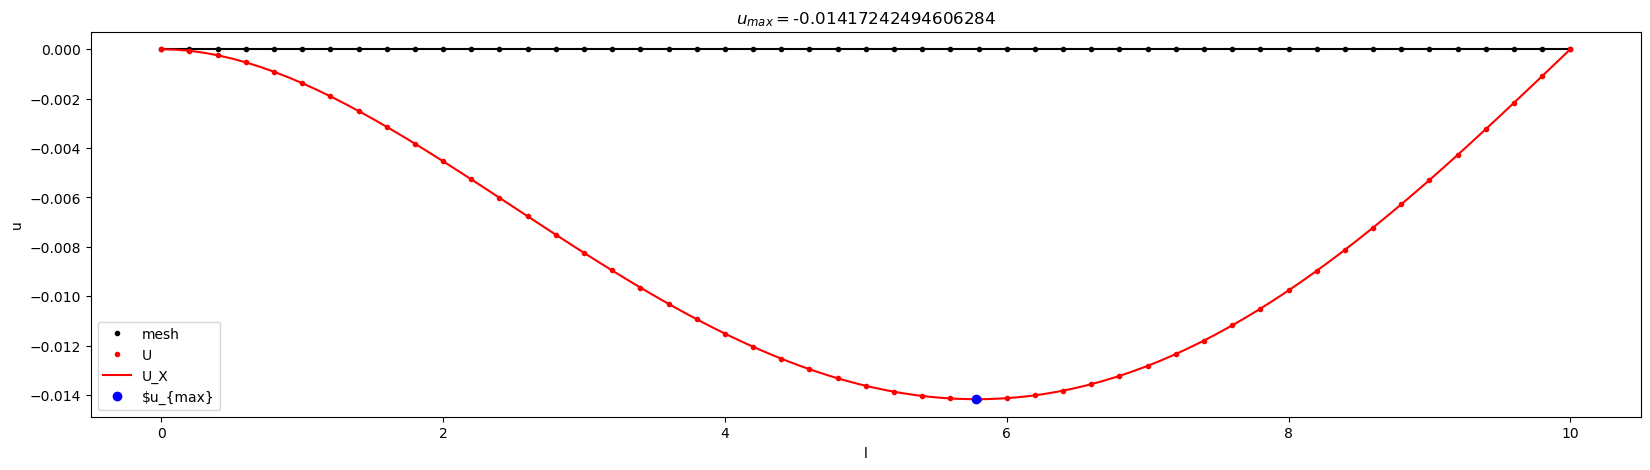

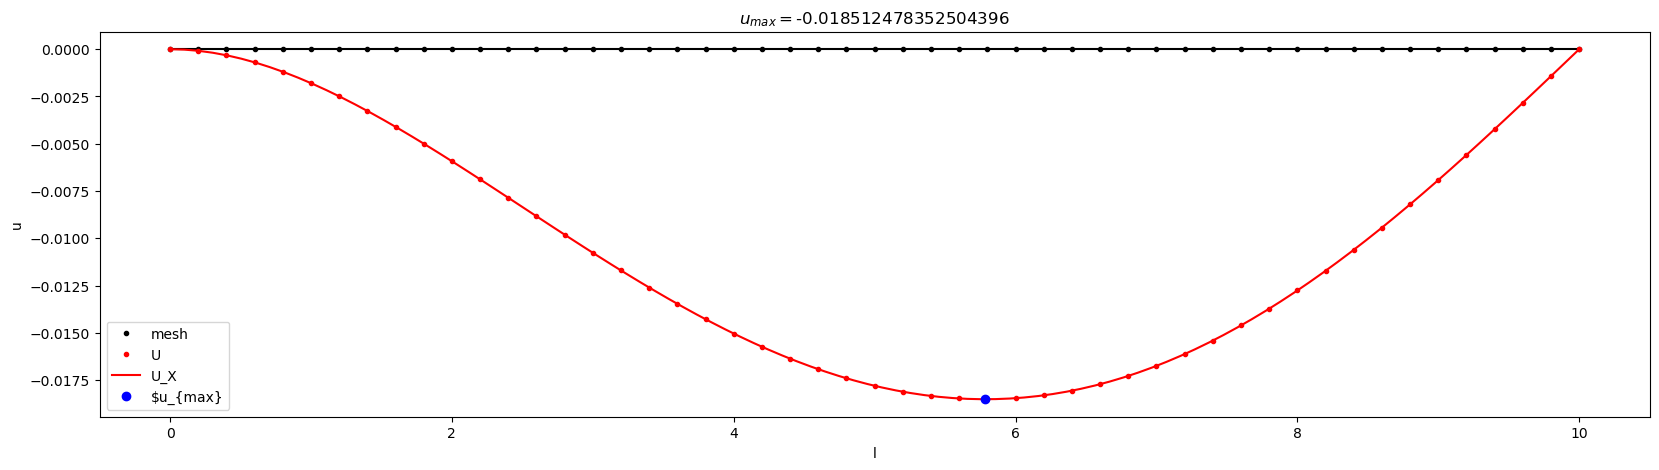

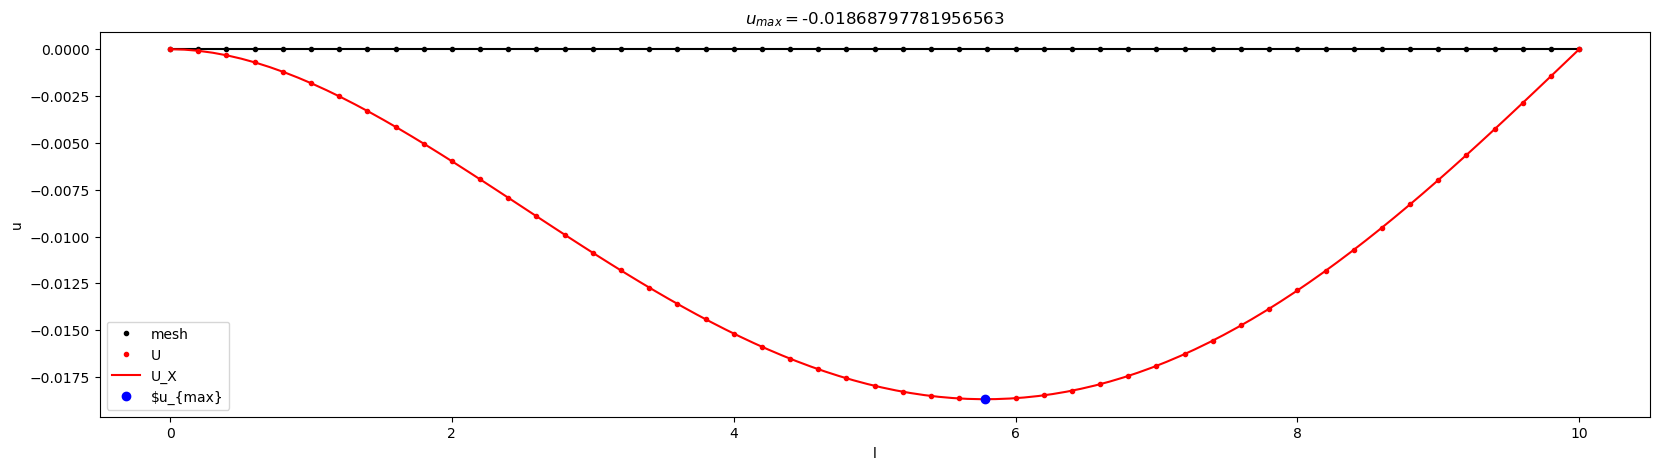

In [7]:
##génération d'échantillons
Echantillon_E = np.array(Loi_E.getSample(3))
Echantillon_b = np.array(Loi_b.getSample(3))
##paramètres
L = 10.0 #longueur en métre
h = 0.1 #hauteur de la section en métre
#Chargement : 
#Chargement total
Q_total = -3000.0 #Newton
#Le chargement est réparti uniformement sur les noeuds entre les 2 extremitées
n_elem = 50
n_nodes = n_elem+1
Q_elem = Q_total/n_elem
Q = np.ones((n_nodes,))*Q_elem
##Exécution du code EF pour chaque échantillon
for i in range(3):
    E = Echantillon_E[i]
    b = Echantillon_b[i]
    I = b*h**3/12.0
    l_max,u_max,U = find_max_dep(n_elem,L,E,I,Q)
    #interpolation de la solution EF
    X = np.linspace(0.0,L,100)
    U_X = interpolation_EF(X,U,L)
    #Représentation graphique
    mesh = np.linspace(0,L,n_elem+1)
    fig,(ax_2) = plt.subplots(1,1,figsize=(20,5))
    #ax_1.plot(mesh,Q,'r.',label="Q")
    #ax_1.plot(mesh,Q,'r')
    #ax_1.set_xlabel('l')
    #ax_1.set_ylabel('Q')
    #ax_1.legend(loc=0)
    ax_2.plot(mesh,np.zeros(mesh.shape),'k.',label='mesh')
    ax_2.plot([0.0,L],[0.0,0.0],'k')
    ax_2.plot(mesh,U[0:-1:2],'r.',label = 'U')
    ax_2.plot(X,U_X,'r',label ='U_X')
    ax_2.plot(l_max,u_max,'bo',label=r'$u_{max}')
    ax_2.set_xlabel('l')
    ax_2.set_ylabel('u')
    ax_2.set_title(r'$u_{max}=$'+str(u_max))
    ax_2.legend(loc=0)

<p class="bg-primary" style="padding:1em">**Question 3) : ** En vous inspirant du code précédent compléter le code suivant afin de générer un échantillon de taille 500 de la valeur $u_{max}$ et tracer l'histogramme correspondant.</p>

/tmp/ipykernel_66941/1518619603.py:47: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n = np.int((x-1e-12)/l) #on se décale très légèrement sur la gauche


Text(0.5, 0, 'u_max')

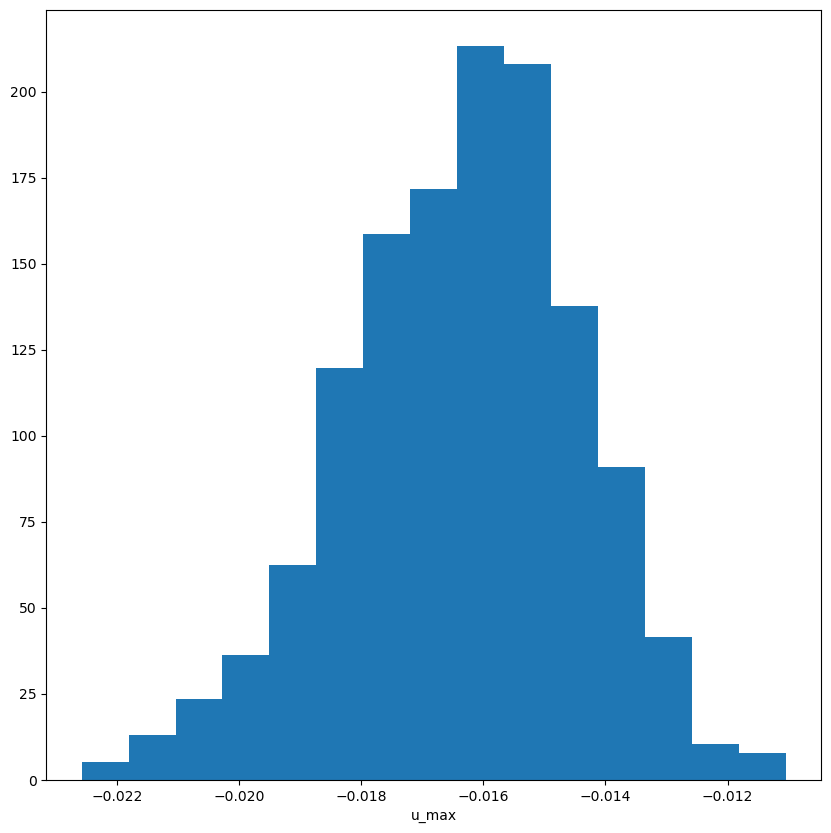

In [8]:
##génération d'échantillons
n_sim = 500
Echantillon_E = np.array(Loi_E.getSample(n_sim))
Echantillon_b = np.array(Loi_b.getSample(n_sim))
##paramètres
L = 10.0 #longueur en métre
h = 0.1 #hauteur de la section en métre
#Chargement : 
#Chargement total
Q_total = -3000.0 #Newton
#Le chargement est réparti uniformement sur les noeuds entre les 2 extremitées
n_elem = 50
n_nodes = n_elem+1
Q_elem = Q_total/n_elem
Q = np.ones((n_nodes,))*Q_elem
#Vecteur U_max
U_max = np.zeros((n_sim,))
##Exécution du code EF pour chaque échantillon
for i in range(n_sim):
    E = Echantillon_E[i]
    b = Echantillon_b[i]
    I = b*h**3/12.0
    l_max,u_max,U = find_max_dep(n_elem,L,E,I,Q)
    U_max[i] = u_max
fig,(ax_2) = plt.subplots(1,1,figsize=(10,10))
ax_2.hist(U_max,15,density=True)
ax_2.set_xlabel('u_max')

## 2-2) Fiabilité

### 2-2-1) Introduction
La fonction de performance est définie par : 
$$
G(X) = d_{seuil}-|u_{max}(X)|
$$
on fixera $d_{seuil}=0.022$

<p class="bg-primary" style="padding:1em">**Question 4) : ** Compléter le code suivant afin d'implémenter la fonction de performance.</p>

In [9]:
def  G(X):
    d_seuil = 0.022
    E = X[0]
    b = X[1]
    #définition des paramètres 
    I = b*h**3/12.
    #Détermination de u_max
    l_max,u_max,U = find_max_dep(n_elem,L,E,I,Q)
    return d_seuil-abs(u_max)

### 2-2-2) Transformation iso-probabiliste


<p class="bg-primary" style="padding:1em">**Question 5) :** Compléter les deux fonctions ci-dessous permettant de passer de l'espace physique à l'espace normal standard et inversement.</p>

In [10]:
N = ot.Normal()
def T_iso_proba(X):
    u_1 = N.computeQuantile(Loi_E.computeCDF(X[0]))
    u_2 = N.computeQuantile(Loi_b.computeCDF(X[1]))
    return np.array([u_1,u_2])
def inv_T_iso_proba(U):
    E = Loi_E.computeQuantile(N.computeCDF(U[0]))
    b = Loi_b.computeQuantile(N.computeCDF(U[1]))
    return np.array([E, b])

### 2-2-3) First Order Reliability method
On rappelle que la mise en oeuvre de la méthode FORM passe par la résolution du problème d'optimisation sous contrainte, 
$$
\min_{u} \sqrt{uu^T}
$$
sous la contrainte $H(u)\leqslant 0$

<p class="bg-primary" style="padding:1em">**Question 6) :** Compléter le code suivant afin de créer la fonction objective et la contrainte du problème d'optimisation. </p>

In [11]:
def f_obj(U):
    y = np.sqrt(np.sum(U**2))
    return y
def H(U):
    X = inv_T_iso_proba(U)
    return -G(X)   

Nous allons à présent résoudre ce problème d'optimisation à l'aide de la bibliothèque d'optimisation scipy.optimize https://docs.scipy.org/doc/scipy/reference/optimize.html. 

<p class="bg-primary" style="padding:1em">**Question 7) : ** En vous aidant de la documentation de la fonction minimize de scipy, utiliser la méthode d'optimisation 'COBYLA' pour résoudre le problème précédent. (Attention au signe de la contrainte)</p>

In [12]:
constraint ={'type':'ineq','fun':H}
x_0 = [0.,0.]
sol_opt = opt.minimize(f_obj,x_0,method = 'COBYLA', constraints = constraint)

/tmp/ipykernel_66941/1518619603.py:47: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n = np.int((x-1e-12)/l) #on se décale très légèrement sur la gauche


<p class="bg-primary" style="padding:1em">**Question 8) : **Compléter le code suivant afin de déterminer :
**la valeur de l'indice de fiabilité d'Hasofer et Lind**,
**l'approximation de la probabilité de défaillance par la méthode FORM**, 
**le nombre de résolution éléments finis effectuées**.


Que pouvez vous dire du coût numérique de cette approche? Quel nombre (approximatif) de simulations serait nécessaire pour estimer cette probabilité par la méthode de Monte-Carlo?</p>

In [13]:
print (sol_opt)
u_star = sol_opt['x']
beta = sol_opt['fun']
n_eval = sol_opt['nfev']
P_f_FORM = N.computeCDF(-beta)
print ("Coordonnés de P_star =", u_star)
print ("Indice d'Hasofer Lind=", beta)
print ("P_f_FORM=", P_f_FORM)
print ("Le simulateur a été utilisé ",n_eval, "fois")

     fun: 2.4880364848026075
   maxcv: 9.225790270628309e-12
 message: 'Optimization terminated successfully.'
    nfev: 50
  status: 1
 success: True
       x: array([-2.24171538, -1.07936912])
Coordonnés de P_star = [-2.24171538 -1.07936912]
Indice d'Hasofer Lind= 2.4880364848026075
P_f_FORM= 0.006422527736380667
Le simulateur a été utilisé  50 fois


On souhaite vérifier la forme de l'état limite $H(u_1,u_2)=0$, dans le plan $(u_1,u_2)$ au voisinage de $P^\star$. Pour cela il faut déterminer les points $(u_1,u_2)$ tels que $H(u_1,u_2)=0$. 

<p class="bg-primary" style="padding:1em">** Question 9) : **Le problème précédent est sous déterminé. Proposez une méthode afin de trouver un nombre $n$ de solutions différentes au voisinage de $P^\star$. Implémenter cette méthode et tracer  l'état limite dans l'espace normal standard. L'hypothèse faite à la question précédente est elle vérifiée?</p>

In [14]:
def f_obj(u_2,u_1):
    X = inv_T_iso_proba(np.array([u_1,u_2]))
    return abs(G(X))   
n = 10
u_1_star = u_star[0]
u_2_star = u_star[1]
delta_u_1 = 0.03
u_sol_p = []
h_sol_p = []
u_sol_m = []
h_sol_m = []
for i in range(n):
    u_1 = u_1_star+delta_u_1
    sol_opt = opt.minimize(f_obj,u_2_star,method = 'COBYLA',args=(u_1))
    u_2_star = sol_opt['x']
    u_sol_p.append([u_1,u_2_star])
    h_sol_p.append(sol_opt['fun'])
    u_1_star = u_1

u_1_star = u_star[0]
u_2_star = u_star[1]
for i in range(n):
    u_1 = u_1_star-delta_u_1
    sol_opt = opt.minimize(f_obj,u_2_star,method = 'COBYLA',args=(u_1))
    u_2_star = sol_opt['x']
    u_sol_m.append([u_1,u_2_star])
    h_sol_m.append(sol_opt['fun'])
    u_1_star = u_1   

/tmp/ipykernel_66941/3813958432.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = inv_T_iso_proba(np.array([u_1,u_2]))
/tmp/ipykernel_66941/1518619603.py:47: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n = np.int((x-1e-12)/l) #on se décale très légèrement sur la gauche


/tmp/ipykernel_66941/2417372740.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  u_sol_p = np.array(u_sol_p)
/tmp/ipykernel_66941/2417372740.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  u_sol_m = np.array(u_sol_m)


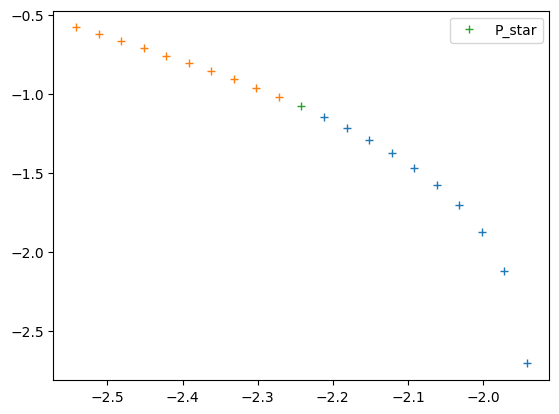

In [15]:
u_1_star = u_star[0]
u_2_star = u_star[1]
u_sol_p = np.array(u_sol_p)
u_sol_m = np.array(u_sol_m)
plt.figure()
plt.plot(u_sol_p[:,0],u_sol_p[:,1],'+')
plt.plot(u_sol_m[:,0],u_sol_m[:,1],'+')
plt.plot(u_1_star,u_2_star,'+',label = 'P_star')
plt.legend()

## 3) Dimensionnement fiabiliste 
On souhaite maintenant optimiser la passerelle de sorte qu'elle soit de masse minimale sous la contrainte de fiabilité $P_f\leq 1e-6$. Pour cela on optimisera sur les variables géométriques $b$ et $h$ du problème. La variable $b$ étant une variable aléatoire nous optimiserons sa moyenne $\mu_B$ en supposant que la variable suit toujours une loi uniforme sur $[\mu_B-0.1,\mu_B+0.1]$.   

Question 9bis) : Ecrire la formulation du problème d'optimisation.

On a : 

$$min_{(b, h)} \space \mu_B \times h $$

Sous la contrainte: 
$$10^{-6} - Pf \geq 0$$

$$

Question 10) : Compléter le code ci-dessous afin d'implémenter la fonction objectif du problème d'optimisation.

In [16]:
def f_obj_opt(X):
    mu_B =  X[0]
    h = X[1]
    return mu_B*h

Question 11) : Le calcul de la contrainte fait intervenir le calcul de la probabilité de défaillance que nous estimons par la méthode FORM. Compléter le code suivant afin d'implémenter le calcul de $P_f^{FORM}$.

In [17]:
def contrainte_fiab(X):
    #modèle probabiliste des variables d'entrée (la loi de E reste inchangée)
    mu_B =  X[0]
    b_inf =  mu_B - 0.1
    b_sup =  mu_B + 0.1
    Loi_b = ot.Uniform(b_inf, b_sup)
    #tranformation iso_proba
    N = ot.Normal()
    
    def inv_T_iso_proba(U):
        E = Loi_E.computeQuantile(N.computeCDF(U[0]))
        b = Loi_b.computeQuantile(N.computeCDF(U[1]))
        return np.array([E, b])
    
    def T_iso_proba(Y): #Y[0] = E, Y[1] = B
        u_1 = N.computeQuantile(Loi_E.computeCDF(Y[0]))
        u_2 = N.computeQuantile(Loi_E.computeCDF(Y[1]))
        return np.array([u_1,u_2])
    
    #FORM
    def  G(Y):
        d_seuil = 0.022
        ##paramètres
        L = 10.0 #longueur en métre
        h = X[1]
        #Chargement : 
        #Chargement total
        Q_total = -3000.0 #Newton
        #Le chargement est réparti uniformement sur les noeuds entre les 2 extremitées
        n_elem = 50
        n_nodes = n_elem+1
        Q_elem = Q_total/n_elem
        Q = np.ones((n_nodes,))*Q_elem
        E = Y[0]
        b = Y[1]
        #définition des paramètres 
        I = b*h**3/12.
        #Détermination de u_max
        l_max, u_max, U = find_max_dep(n_elem,L,E,I,Q)
        return d_seuil-abs(u_max)

    def f_obj_FORM(U):
        y = np.sqrt(np.sum(U**2))
        return y
    
    def H(U):
        Y = inv_T_iso_proba(U)
        return -G(Y) 
    
    constraint ={'type':'ineq','fun':H}
    x_0 = [0.,0.]
    sol_opt = opt.minimize(f_obj_FORM, x_0, method = 'COBYLA', constraints = constraint) 
    u_star = sol_opt['x']
    beta = sol_opt['fun']
    n_eval = sol_opt['nfev']
    P_f_FORM = N.computeCDF(-beta)
    return 1e-6 - P_f_FORM 
    
    

On peut vérifier l'implémentation de la contrainte au point étudié précédemment

In [18]:
X = np.array([1.,0.1])
P_f_FORM = -contrainte_fiab(X) + 1e-6
print (P_f_FORM) # proba: should be positive

/tmp/ipykernel_66941/1518619603.py:47: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n = np.int((x-1e-12)/l) #on se décale très légèrement sur la gauche


0.006422527736380667


Question 12) : Dans un premier temps nous allons explorer le domaine de variation de $\mu_B$ et $h$. Compléter le code ci-dessous afin de tracer les iso-valeurs de la fonction $(\mu_B,h)\rightarrow P_f^{FORM}$. Interpréter le résultat obtenu.

In [19]:
n = 10
mu_B_dis = np.linspace(0.5,1.1,n)
h_dis = np.linspace(0.07,0.11,n)
P_f_FORM_dis = []
for mu_B in mu_B_dis:
    for h in h_dis:
        X=[mu_B,h]
        P_f_FORM = -contrainte_fiab(X) + 1e-6
        P_f_FORM_dis.append(P_f_FORM)        

/tmp/ipykernel_66941/1518619603.py:47: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n = np.int((x-1e-12)/l) #on se décale très légèrement sur la gauche


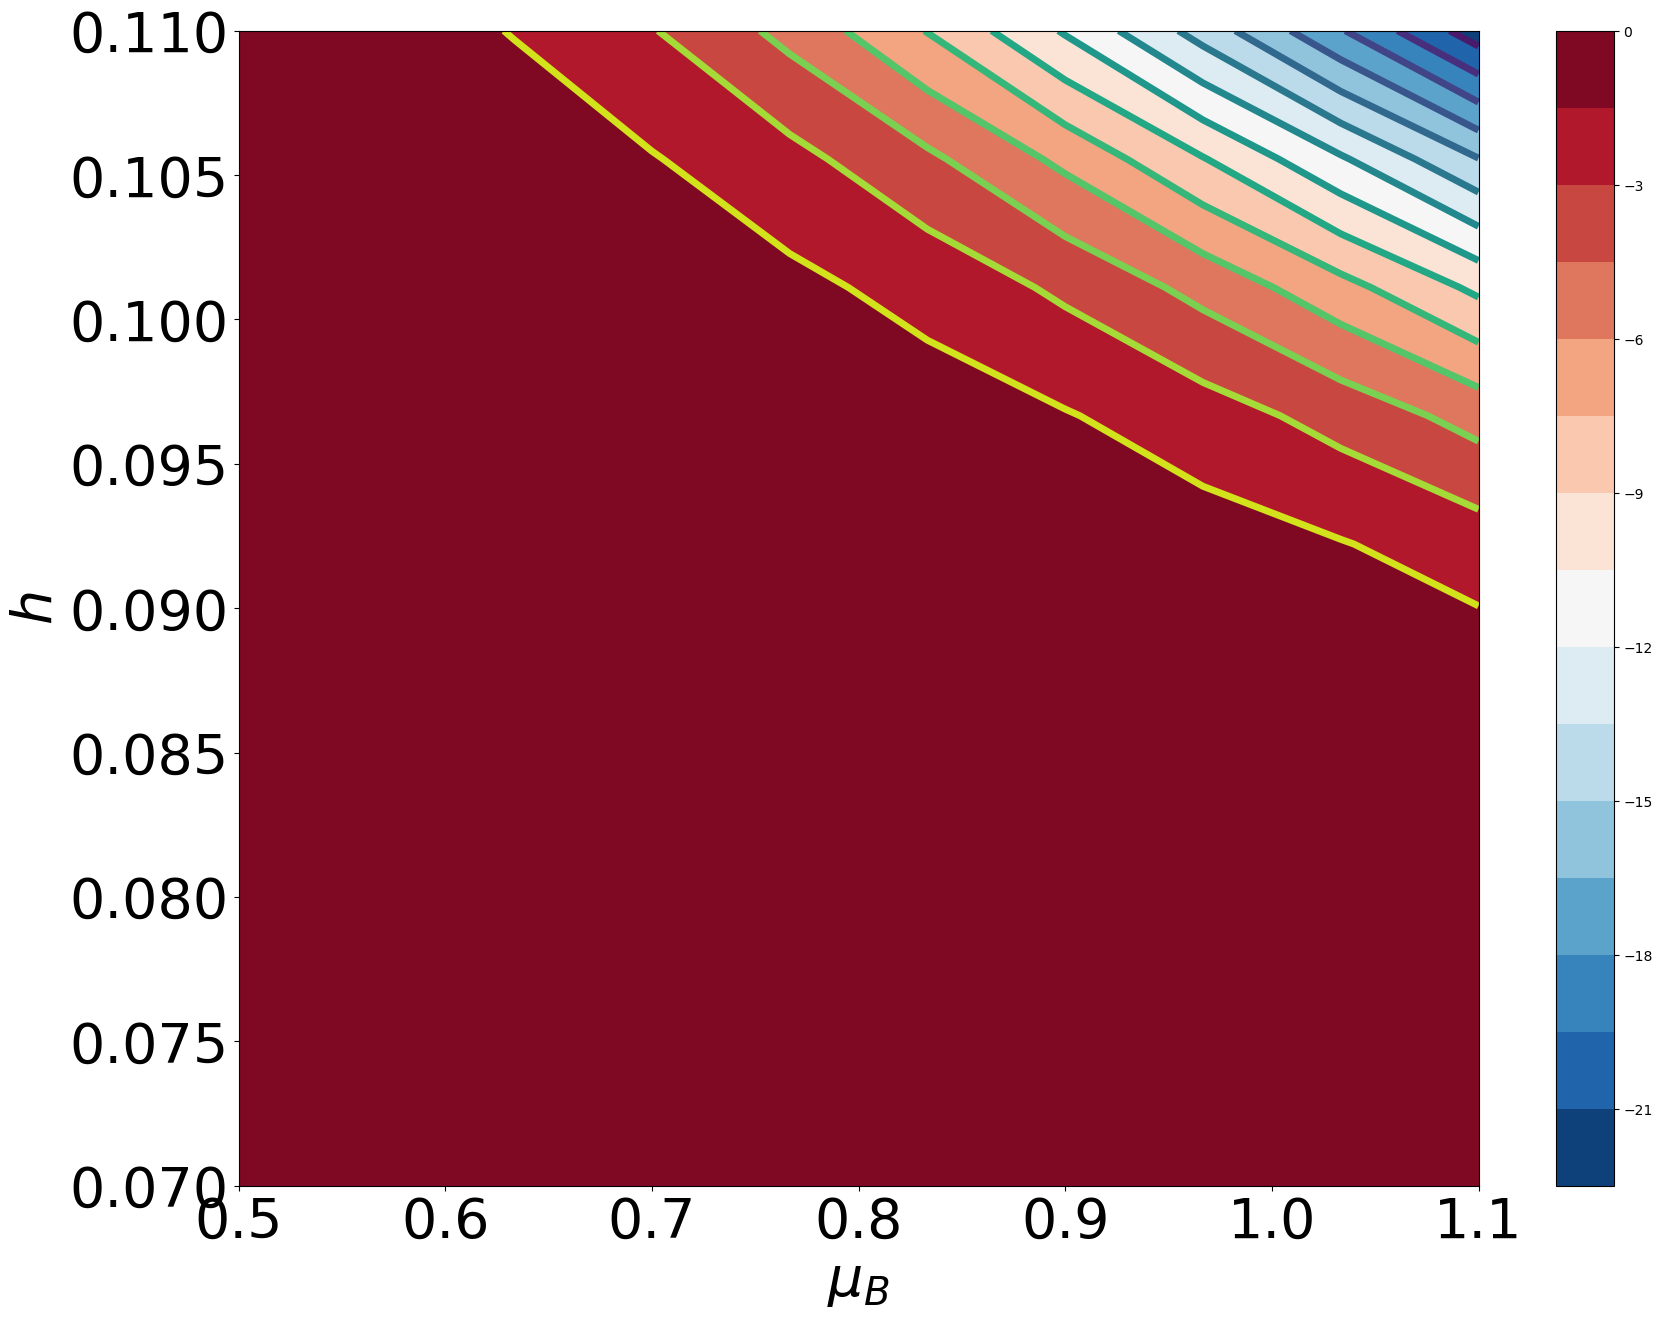

In [20]:
P_f_FORM_dis = np.array(P_f_FORM_dis)
P_f_FORM_dis = P_f_FORM_dis.reshape((n,n)).T
P_f_FORM_log = np.log(P_f_FORM_dis)
X1,X2 = np.meshgrid(mu_B_dis,h_dis)
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111)
ax.set_xlabel(r'$\mu_B$',fontsize = 40)
ax.set_ylabel (r'$h$',fontsize=40)
ax.tick_params(labelsize=40)
ax.contour(X1,X2,P_f_FORM_log,levels = 20,linewidths=5) 
cs = ax.contourf(X1,X2,P_f_FORM_log,levels = 20,cmap="RdBu_r")
fig.colorbar(cs, ax=ax)

Nous allons maintenant résoudre le problème à l'aide de l'algorithme d'optimisation SLSQP. 

<p class="bg-primary" style="padding:1em">** Question 13) : **Compléter le code ci-dessous afin de réaliser l'optimisation </p>

In [21]:
cont_fiab = {'type':'ineq','fun': contrainte_fiab}
X_0  = [1.0,0.1]
bds = [[0.5,1.1],[0.07,0.11]]
res_opt_masse = opt.minimize(f_obj_opt, X_0, method = 'SLSQP', constraints = cont_fiab, bounds = bds, tol=1e-8)

/tmp/ipykernel_66941/1518619603.py:47: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n = np.int((x-1e-12)/l) #on se décale très légèrement sur la gauche


In [22]:
print("la masse optimisée est : ",res_opt_masse)
print ("la probabilité de défaillance en ce point est estimée à : ",-contrainte_fiab(res_opt_masse['x'])+1e-6)


la masse optimisée est :       fun: 0.10571614388372857
     jac: array([0.11      , 0.96105585])
 message: 'Optimization terminated successfully'
    nfev: 46
     nit: 15
    njev: 15
  status: 0
 success: True
       x: array([0.96105585, 0.11      ])


/tmp/ipykernel_66941/1518619603.py:47: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n = np.int((x-1e-12)/l) #on se décale très légèrement sur la gauche


la probabilité de défaillance en ce point est estimée à :  9.999999134885976e-07


La contrainte est saturée parce que, en essayant de minimiser la masse de la passerelle, on tend vers un maximum de la probabilité de defaillance. Cela fait qu'on se trouve toujours sur la contrainte à une tolérance près à la fin de l'optimisation.

## 4)  Monte-Carlo

On se replacera au point initial $b = 1$ $h = 0.1$ (n'oubliez pas d'executer à nouveau la definition de la fonction G, la contruction des lois et des transformations iso-probabilistes pour ce point). On souhaite utiliser la méthode de Monte-Carlo pour vérifier l'approximation obtenue par la méthode FORM. 

Question 14) : Completer le code suivant afin d'implémenter la méthode de Monte Carlo sur cet exemple. Que pouvez-vous dire de l'approximation obtenue par  la méthode FORM? Est-ce cohérent avec la forme de l'état limite au voisinage de $P^{\star}$?

In [23]:
b = 1.
h = 0.1
print(u_star)

[-2.24171538 -1.07936912]


In [24]:
#Paramètres géométriques
L = 10.0 #longueur en métre
h = 0.1 #hauteur de la section en métre
##Définitions des paramètres
n_elem = 50
n_nodes = n_elem + 1
Q_total = -3000.0
mu = Q_total/(n_nodes)
n_sim_max = 10**5
cov_max = 0.1
Indicatrice_Df = []
Liste_Cov = []
Liste_n_sim = []
i = 0
cov = 1.0
t1 = t.time()
while i<n_sim_max and cov>cov_max:
    #Echantillon
    E = np.array(Loi_E.getSample(1))
    b = np.array(Loi_b.getSample(1))
    X = np.array([E,b])
    g = G(X)
    if g>0:
        Indicatrice_Df.append(0)
    else:
        Indicatrice_Df.append(1)
    Pf = np.array(Indicatrice_Df).mean()    
    if np.equal(np.mod(i/100.0, 1), 0):
        cov = np.sqrt((1.0-Pf)/((i+1)*Pf))
        Liste_Cov.append(cov)
        Liste_n_sim.append(i+1)
    i = i+1    
t2 = t.time()  

/tmp/ipykernel_66941/1518619603.py:47: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n = np.int((x-1e-12)/l) #on se décale très légèrement sur la gauche
/tmp/ipykernel_66941/2287261732.py:29: RuntimeWarning: divide by zero encountered in double_scalars
  cov = np.sqrt((1.0-Pf)/((i+1)*Pf))


n_sim= 21301
Pf= 0.004694615276278109
Pf_sup= [0.00561263]
Pf_inf [0.0037766]
L'analyse a duré,  201.74906611442566


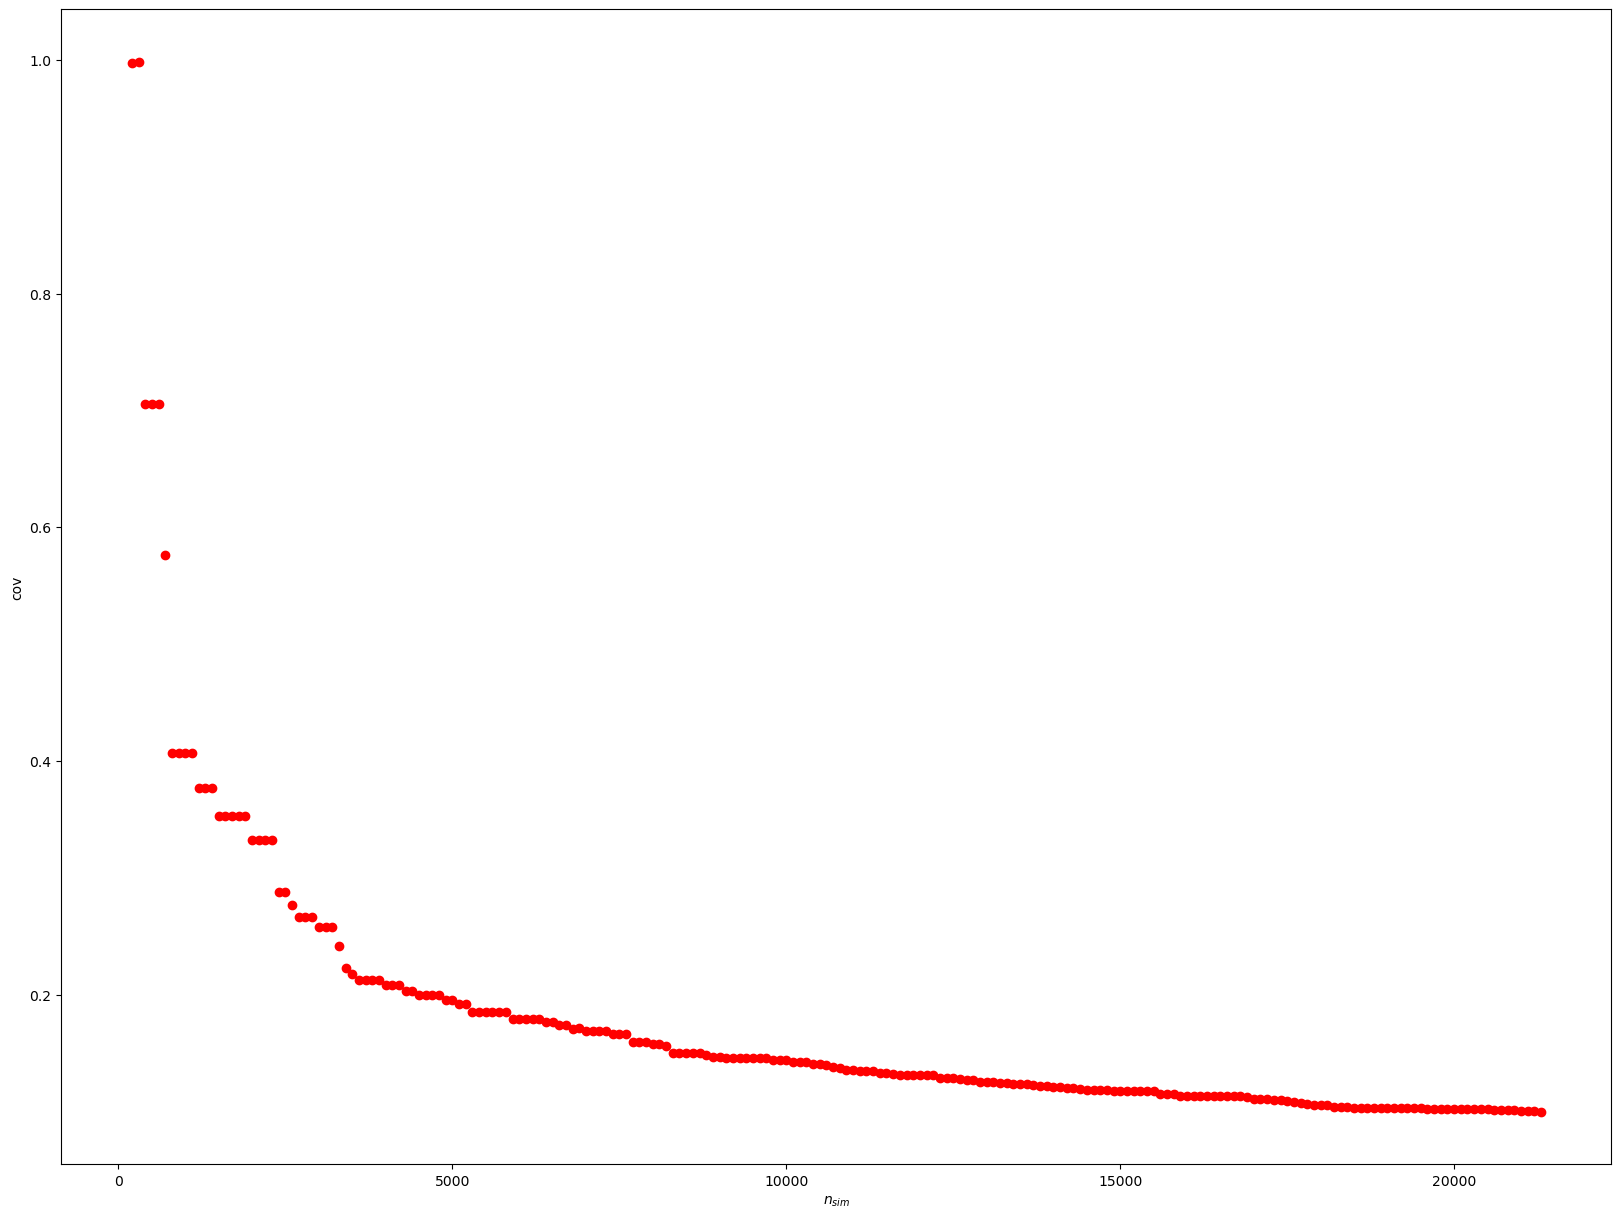

In [25]:
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111)
ax.plot(Liste_n_sim,Liste_Cov,'ro')
ax.set_ylabel('cov')
ax.set_xlabel(r'$n_{sim}$')

#Intervalle de confiance à 95%
#Loi de student à n_sim-1 ddl
n_sim = len(Indicatrice_Df)
Var = 1.0/n_sim*Pf*(1.0-Pf)
Stu = ot.Student(n_sim-1)
alpha = 0.05
q_t = Stu.computeQuantile(1.0-alpha/2.0)
Pf_sup = Pf+q_t*np.sqrt(Var)
Pf_inf = Pf-q_t*np.sqrt(Var)
print ("n_sim=", n_sim)
print ("Pf=", Pf)
print ("Pf_sup=", Pf_sup)
print ("Pf_inf", Pf_inf)
print ("L'analyse a duré, ", t2-t1)

### 5) Tirage d'importance, approche FORM

Nous allons à présent estimer la probabilité de défaillance par importance sampling. On rappelle que l'estimateur de $P_f$ par importance sampling est :
$$
\hat{P}_{f_{is}} = \frac{1}{n_{sim}} \sum_{k= 1}^{n_{sim}} \frac{\mathbf{I}_{G(Y^{(k)})\leq0}(Y^{(k)})f_X(Y^{(k)})}{f_Y(Y^{(k)})}
$$

et l'estimation de sa variance est :
$$
\hat{\sigma}_{\hat{P_{f_{is}}}}^2 = \frac{1}{n_{sim}^2}\sum_{k=1}^{n_{sim}} \left(  \frac{\mathbf{I}_{G(Y^{(k)})\leq0}(Y^{(k)})f_X(Y^{(k)})}{f_Y(Y^{(k)})}- \hat{P}_{f_{is}}\right)^2
$$

<p class="bg-primary" style="padding:1em">** Question 15) : **Mettre en oeuvre, dans l'espace normale standard,la méthode de Monte-Carlo et la méthode de tirage d'importance. Pour le tirage d'importance on utilisera pour densité auxiliaire une loi normale centrée sur le point $P^\star$. Comparer les 2 approches et conclure. </p>

In [26]:
#graine du générateur de nombre aléatoire
np.random.seed(seed=0)
#Paramètres géométriques
L = 10.0 #longueur en métre
h = 0.1 #hauteur de la section en métre
##Définitions des paramètres
n_elem = 50
n_nodes = n_elem + 1
Q_total = -3000.0
mu = Q_total/(n_nodes)
#Monte Carlo dans l'espace normal standard
#Loi normale centrée réduite
N = ot.Normal()
n_sim_max = 10**5
cov_max = 0.1
Indicatrice_Df = []
Liste_Cov = []
Liste_n_sim = []
i = 0
cov = 1.0
N_2 = ot.Normal(2)
t1 = t.time()
#############ANALYSE MC##########
while i<n_sim_max and cov>cov_max:
    #Echantillon
    U = np.array(N_2.getRealization())
    #print(U)
    X = inv_T_iso_proba(U)
    g = G(X)

    if g>0:
        Indicatrice_Df.append(0)
    else:
        Indicatrice_Df.append(1)
    Pf = np.array(Indicatrice_Df).mean()    
    if np.equal(np.mod(i/100.0, 1), 0):
        cov = np.sqrt((1.0-Pf)/((i+1)*Pf))
        Liste_Cov.append(cov)
        Liste_n_sim.append(i+1)
    i = i+1    
t2 = t.time()
#Importance sampling
#loi normale centrée réduite en 2D
N_2 = ot.Normal(2)
#loi auxiliaire
N_IS =  ot.Normal(ot.Point(u_star), ot.CorrelationMatrix(2))
n_sim_max = 10**5
cov_max = 0.1
Indicatrice_IS = []
Indicatrice = []
Liste_Cov_IS = []
Liste_n_sim_IS = []
Liste_w_i = []
i = 0
cov = 1.0
t3 = t.time()
############ANALYSE IC########
while i<n_sim_max and cov>cov_max:
    #Echantillon
    U = np.array(N_IS.getRealization())
    IR = N_2.computePDF(U)/N_IS.computePDF(U)
    X = inv_T_iso_proba(U)
    g = G(X)
    
    if g>0:
        Indicatrice.append(0)
        Indicatrice_IS.append(0.)
    else:
        Indicatrice.append(1)
        Indicatrice_IS.append(IR)

    Pf = np.array(Indicatrice).mean()
    Pf_IS = np.array(Indicatrice_IS).mean()    
    
    if i>10: # and np.equal(np.mod(i/100.0, 1), 0):
        n = len(Indicatrice_IS)
        # sigma_2 = np.array(Indicatrice_IS).var()
        sigma_2 = np.sum((np.array(Indicatrice_IS) - Pf_IS)**2)/n**2
        cov = np.sqrt(sigma_2)/Pf_IS # VARIATION COEFFICIENT
        Liste_Cov_IS.append(cov) # /Pf_IS)
        Liste_n_sim_IS.append(i+1)
        Liste_w_i.append(IR)

    i = i+1    
t4 = t.time()

/tmp/ipykernel_66941/1518619603.py:47: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  n = np.int((x-1e-12)/l) #on se décale très légèrement sur la gauche
/tmp/ipykernel_66941/1758169042.py:37: RuntimeWarning: divide by zero encountered in double_scalars
  cov = np.sqrt((1.0-Pf)/((i+1)*Pf))


###########################
IMPORTANCE SAMPLING
n_sim= 385
Pf= 0.004629621363888533
Pf_sup= [0.00553575]
Pf_inf [0.00372349]
L'analyse a duré,  2.3125228881835938
###########################
Monte Carlo
n_sim= 21601
Pf= 0.43636363636363634
Pf_sup= 0.44297756153932677
Pf_inf 0.4297497111879459
L'analyse a duré,  199.84755325317383


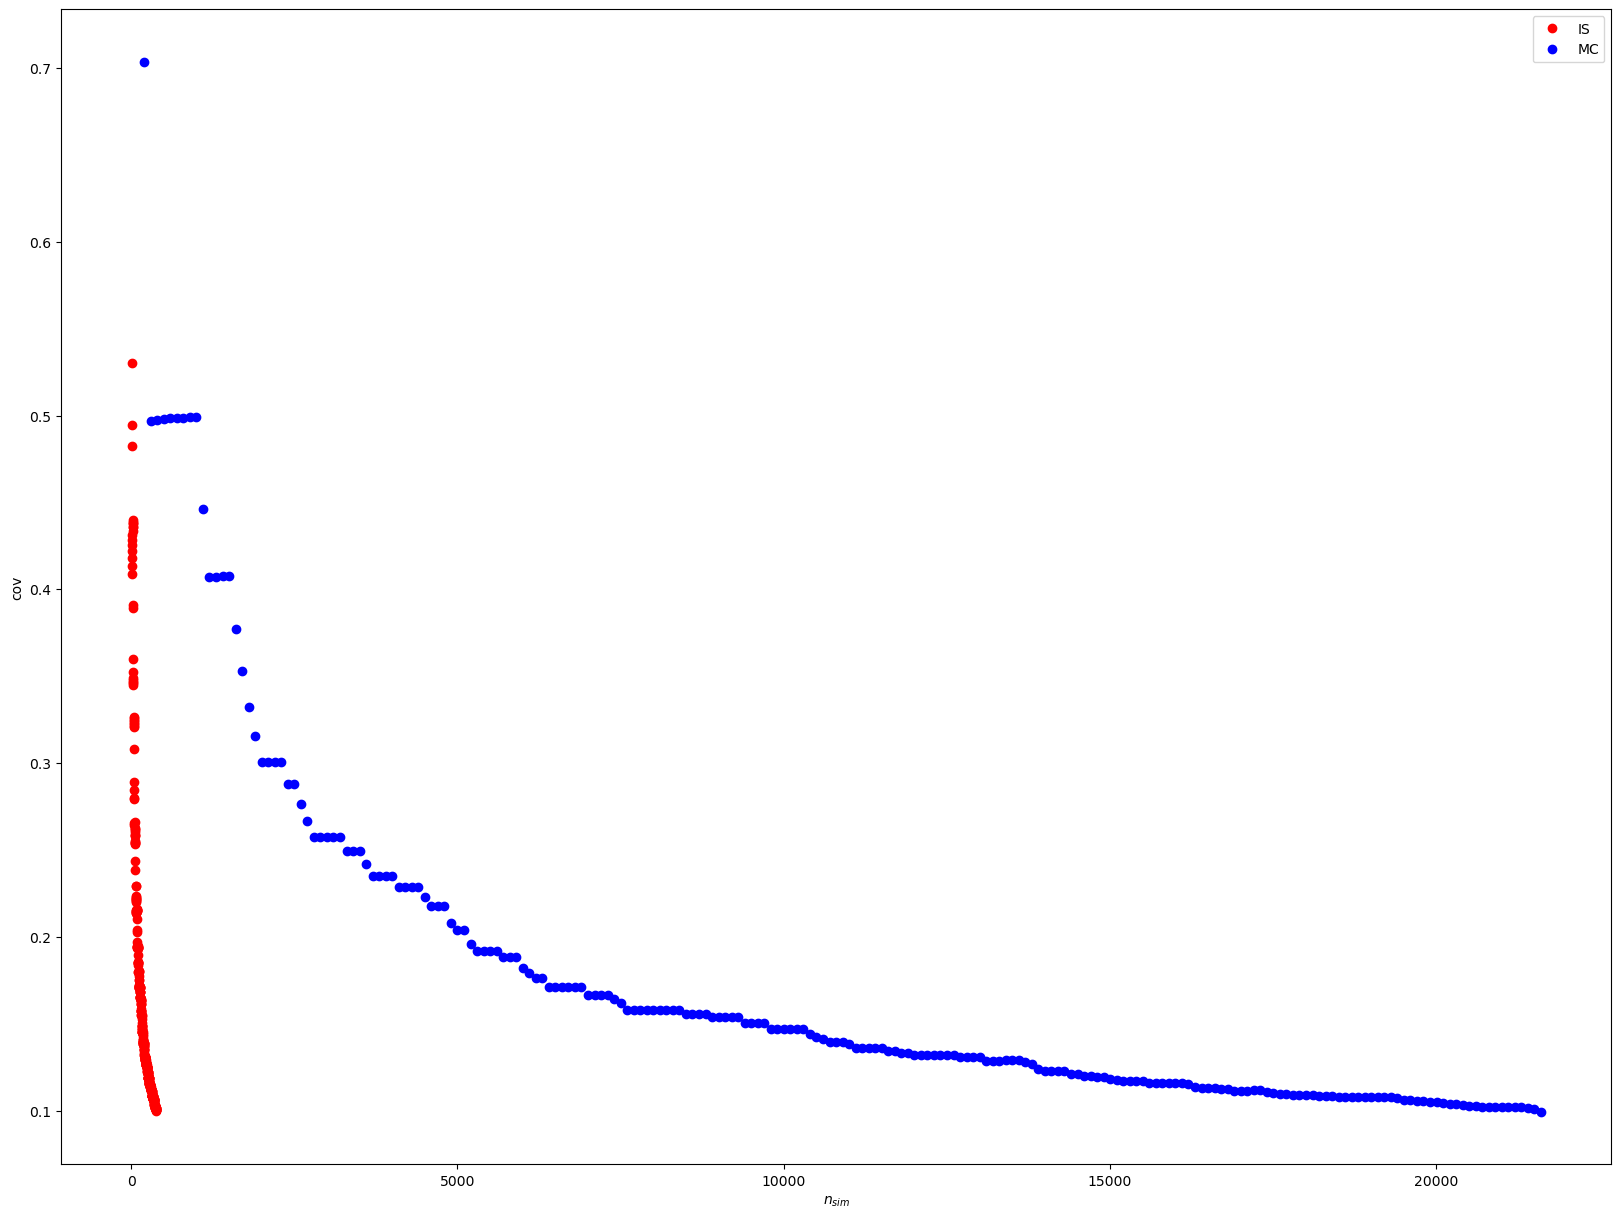

In [27]:
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111)
ax.plot(Liste_n_sim_IS,Liste_Cov_IS,'ro', label = 'IS')
ax.plot(Liste_n_sim,Liste_Cov, 'bo', label='MC')
ax.set_ylabel('cov')
ax.set_xlabel(r'$n_{sim}$')
ax.legend()
#IMPORTANCE SAMPLING
#Intervalle de confiance à 95%
#Loi de student à n_sim-1 ddl
n_sim = len(Indicatrice_IS)
Var = sigma_2
Stu = ot.Student(n_sim-1)
alpha = 0.05
q_t = Stu.computeQuantile(1.0-alpha/2.0)
Pf_sup = Pf_IS+q_t*np.sqrt(Var)
Pf_inf = Pf_IS-q_t*np.sqrt(Var)
print("###########################")
print("IMPORTANCE SAMPLING")
print("n_sim=", n_sim)
print("Pf=", Pf_IS)
print("Pf_sup=", Pf_sup)
print("Pf_inf", Pf_inf)
print("L'analyse a duré, ", t4-t3)
#MONTE CARLO
#Intervalle de confiance à 95%
#Loi de student à n_sim-1 ddl
n_sim = len(Indicatrice_Df)
Var = 1.0/n_sim*Pf*(1.0-Pf)
Stu = stat.t(n_sim-1)
alpha = 0.05
q_t = Stu.ppf(1.0-alpha/2.0)
Pf_sup = Pf+q_t*np.sqrt(Var)
Pf_inf = Pf-q_t*np.sqrt(Var)
print("###########################")
print("Monte Carlo")
print("n_sim=", n_sim)
print("Pf=", Pf)
print("Pf_sup=", Pf_sup)
print("Pf_inf", Pf_inf)
print("L'analyse a duré, ", t2-t1)

## BONUS : Importance sampling non parametrique (NIS)
Nous venons de voir que le tirage d'importance permet de réduire considérablement le temps de calcul de la méthode de Monte-Carlo. Toutefois pour la construction de la densité auxiliaire nous nous sommes appuyés sur l'analyse FORM qui suppose qu'il n'y a qu'un seul point de conception. 

On propose à présent d'étudier la fonction suivante de dimension 2 ayant 4 zones de défaillance dans l'espace normal standard.

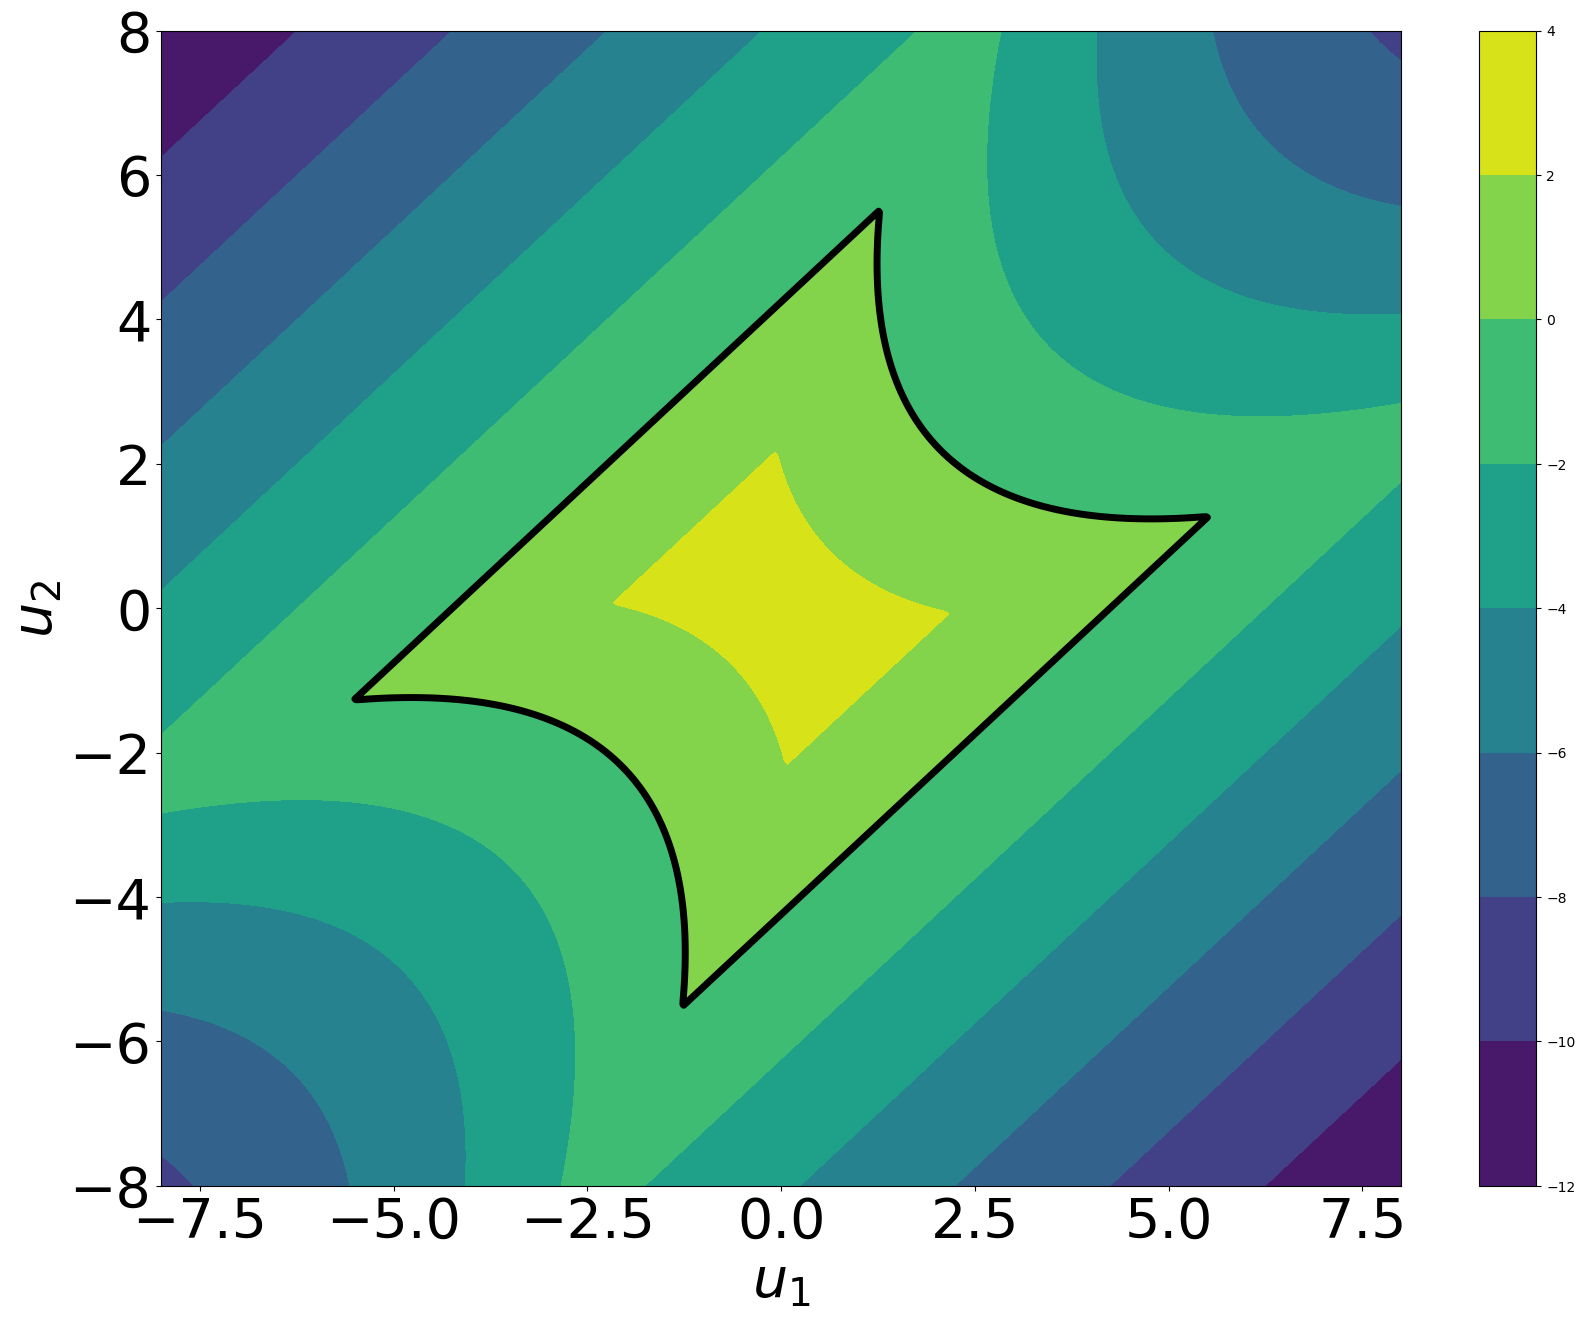

In [28]:
def g(x):
    k = 6.0
    Y1 = 3.0 + 0.1*(x[0]-x[1])**2-((x[0]+x[1])/np.sqrt(2.0))
    Y2 = 3.0 + 0.1*(x[0]-x[1])**2+((x[0]+x[1])/np.sqrt(2.0))
    Y3 = (x[0]-x[1])+k/np.sqrt(2.0)
    Y4 = (x[1]-x[0])+k/np.sqrt(2.0)
    return min(Y1,Y2,Y3,Y4)

X = np.linspace(-8.0,8.0,300)
res_tot = []
for x1 in X:
    res = []
    for x2 in X:
        x = np.array([x1,x2])
        res.append(g(x))
    res_tot.append(res)        

res_tot = np.array(res_tot)
X1,X2 = np.meshgrid(X,X)
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111)
ax.set_xlabel(r'$u_1$',fontsize = 40)
ax.set_ylabel (r'$u_2$',fontsize=40)
ax.tick_params(labelsize=40)
ax.contour(X1,X2,res_tot,levels = np.array([0.0]),colors = 'k',linewidths=5) 
cs = ax.contourf(X1,X2,res_tot)
fig.colorbar(cs, ax=ax)

Question 16) : Mettre en oeuvre, dans l'espace normale standard,la méthode de Monte-Carlo.

In [29]:
#graine du générateur de nombre aléatoire
np.random.seed(seed=1)
#Monte Carlo dans l'espace normal standard
#Loi normale centrée réduite
N = ot.Normal()
n_sim_max = 10**5
cov_max = 0.1
Indicatrice_Df = []
Liste_Cov = []
Liste_n_sim = []
i = 0
cov = 1.0
t1 = t.time()
#A compléter 
while i<n_sim_max and cov>cov_max:
    #Echantillon
    U = np.array([N.getRealization(), N.getRealization()])
    if g(U) > 0.0:
        Indicatrice_Df.append(0)
    else:
        Indicatrice_Df.append(1)
    Pf = np.array(Indicatrice_Df).mean()    
    if i>10 and np.equal(np.mod(i/100.0, 1), 0):
        cov = np.sqrt((1.0-Pf)/((i+1)*Pf))
        Liste_Cov.append(cov)
        Liste_n_sim.append(i+1)
    i = i+1    
t2 = t.time()

In [30]:
print (i)
print (cov)
n_sim = len(Indicatrice_Df)
Var = 1.0/n_sim*Pf*(1.0-Pf)
Stu = stat.t(n_sim-1)
alpha = 0.05
q_t = Stu.ppf(1.0-alpha/2.0)
Pf_sup = Pf+q_t*np.sqrt(Var)
Pf_inf = Pf-q_t*np.sqrt(Var)
print("###########################")
print("Monte Carlo")
print("n_sim=", n_sim)
print("Pf=", Pf)

22601
0.09928113752964036
###########################
Monte Carlo
n_sim= 22601
Pf= 0.004468828812884386


Question 17) : A partir d'un echantillon de taille $n$, nous allons chercher à construire une densité auxillaire qui se rapproche de la densité optimale. Pour cela nous utiliserons un estimateur non paramétrique à noyau (voir [ici](https://openturns.github.io/openturns/latest/user_manual/_generated/openturns.KernelSmoothing.html?highlight=kernelsmoothing) et [là](https://openturns.github.io/openturns/latest/auto_data_analysis/distribution_fitting/plot_estimate_non_parametric_distribution.html?highlight=kernelsmoothing) ).

In [35]:
#creation de l'échantillon de taille 
n = 5000
#graine du générateur de nombre aléatoire
np.random.seed(seed=1)
#Loi normale centrée réduite
N = ot.Normal()
n_sim_max = n
Indicatrice_Df = []
Liste_Cov = []
Liste_n_sim = []
i = 0
cov = 1.0
Liste_U = np.zeros((n,2))
while i<n_sim_max:
    #Echantillon dans l'espace normal standard
    U_1 = np.array(N.getRealization())
    U_2 = np.array(N.getRealization())
    U = np.array([U_1,U_2])
    Liste_U[i,0] = U_1
    Liste_U[i,1] = U_2
    if g(U)>0.0:
        Indicatrice_Df.append(0)
    else:
        Indicatrice_Df.append(1)
    Pf = np.array(Indicatrice_Df).mean()
    i = i+1    

(18, 2)


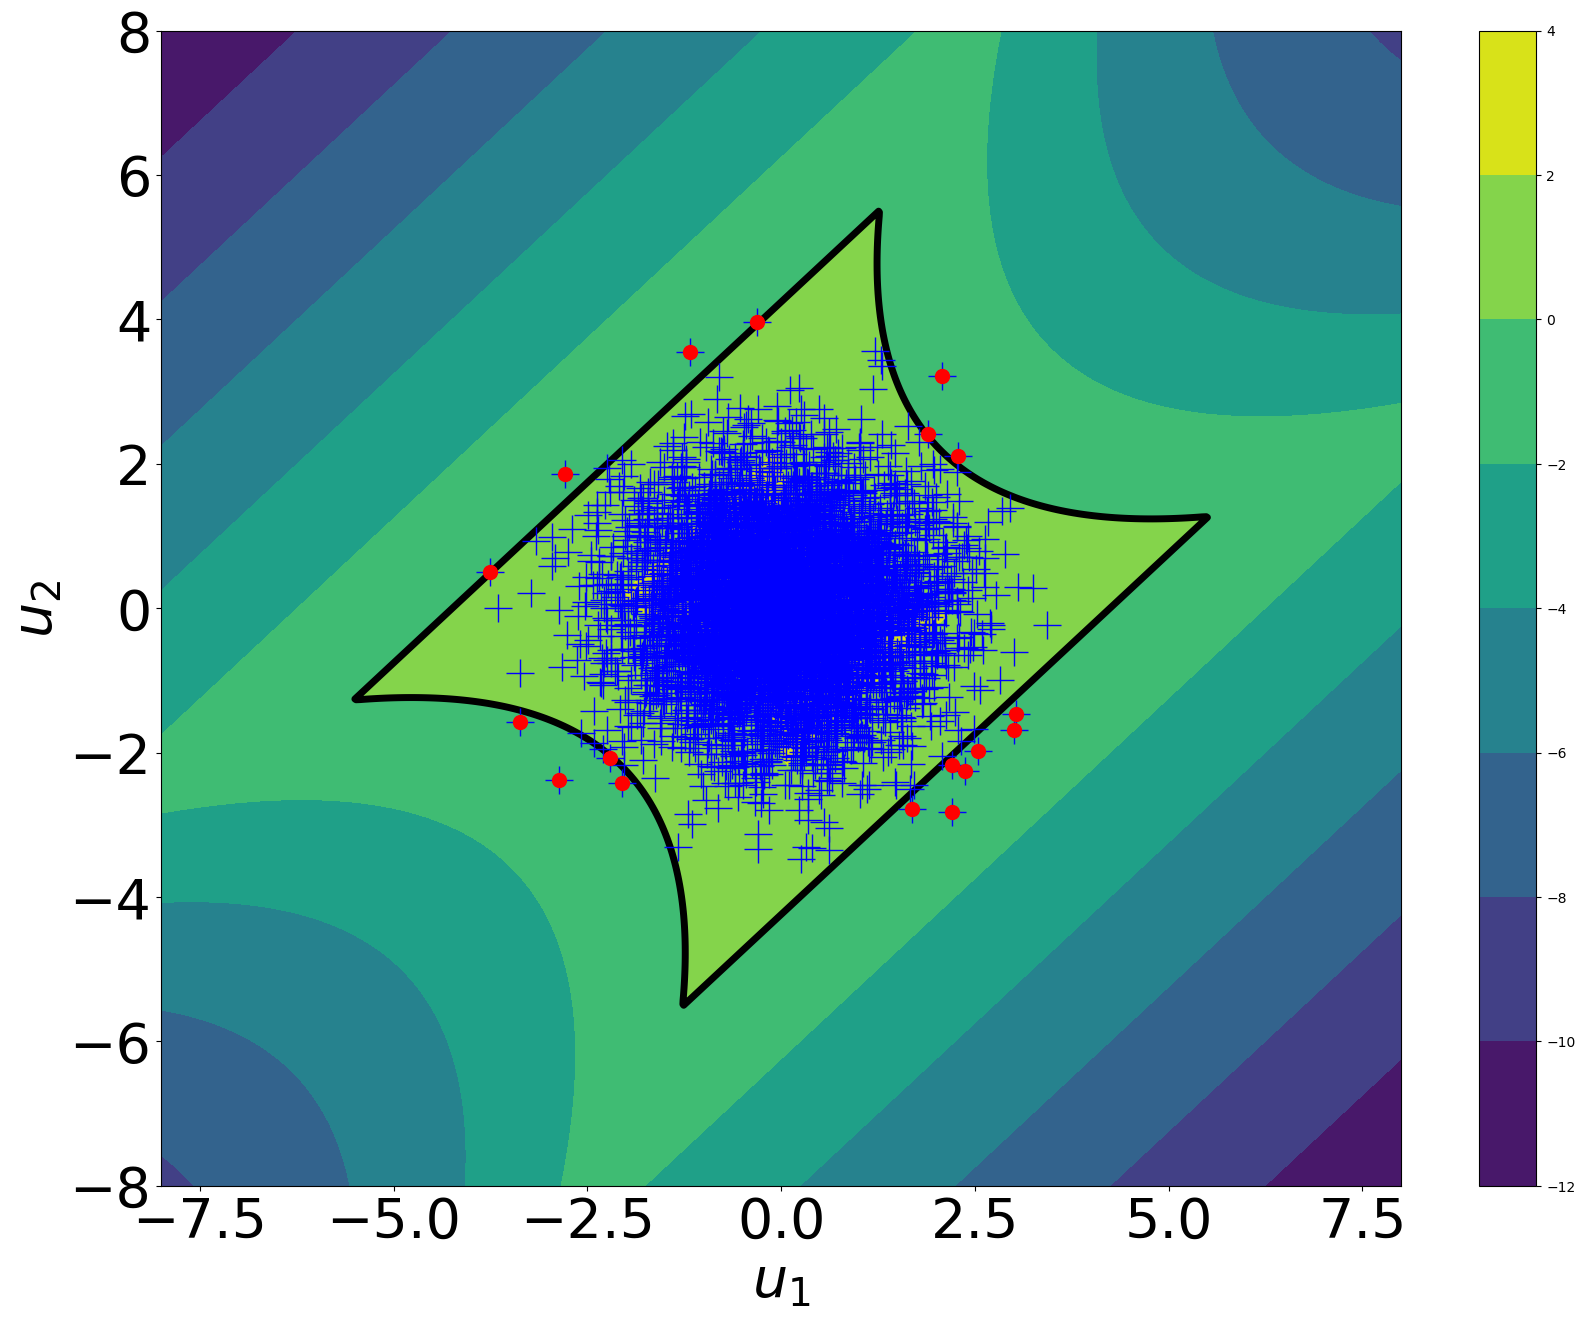

In [66]:
#On conserve uniquement les échantillons défaillants
ind = np.array(Indicatrice_Df) == 1
sample_def = Liste_U[ind, :]
print(sample_def.shape)
#figure des échantillons défaillant
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111)
ax.set_xlabel(r'$u_1$',fontsize = 40)
ax.set_ylabel (r'$u_2$',fontsize=40)
ax.tick_params(labelsize=40)
ax.contour(X1,X2,res_tot,levels = np.array([0.0]),colors = 'k',linewidths=5) 
cs = ax.contourf(X1,X2,res_tot)
ax.plot(Liste_U[:,0],Liste_U[:,1],'b+',markersize=20,label = 'echantillons')
ax.plot(sample_def[:,0],sample_def[:,1],'r.',markersize=20,label = 'echantillons defaillants')
# fig.legend(loc=0)
fig.colorbar(cs, ax=ax);

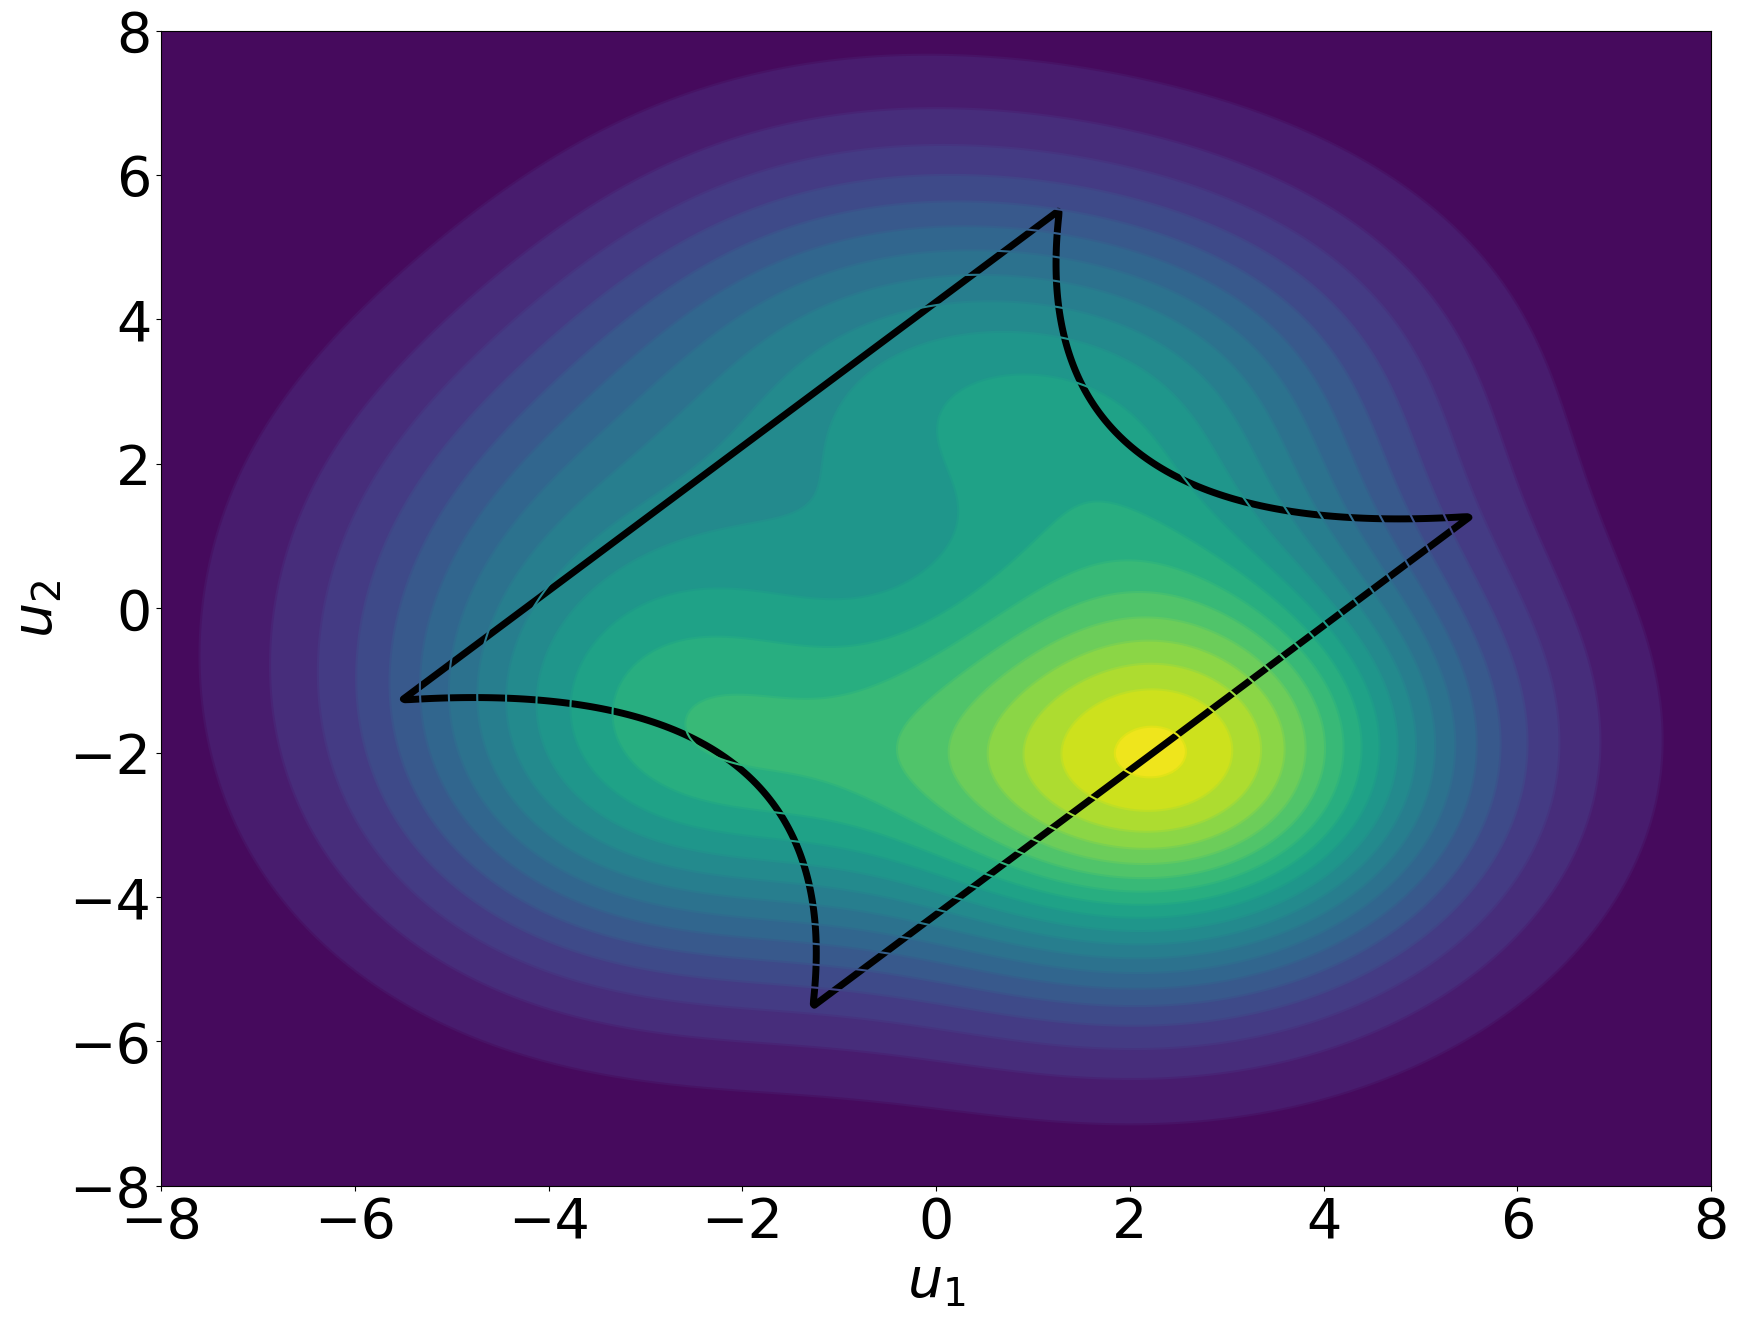

In [57]:
#constructions de la densité non paramétrique
kernel = ot.KernelSmoothing()
pdf_estimated = kernel.build(sample_def) #A compléter)
#graph de la pdf estimée 
# PDF = []
# for x1 in X:
#     pdf = []
#     for x2 in X:
#         x = np.array([x1,x2])
#         pdf.append(pdf_estimated.computePDF(x))
#     PDF.append(pdf)        
# PDF = np.array(PDF)
PDF = np.array(pdf_estimated.computePDF(np.stack([X1.flatten(), X2.flatten()], axis=1))).reshape(300, 300)
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111)
ax.set_xlabel(r'$u_1$',fontsize = 40)
ax.set_ylabel (r'$u_2$',fontsize=40)
ax.tick_params(labelsize=40)
ax.contour(X1,X2,res_tot,levels = np.array([0.0]),colors = 'k',linewidths=5) 
ax.contour(X1,X2,PDF,levels=20)
ax.contourf(X1,X2,PDF,levels=20);

<p class="bg-primary" style="padding:1em">** Question 18) : ** Compléter le code suivant afin d'utilser la densité auxiliaire créée pour le tirage d'importance.</p>

In [70]:
N_2 = ot.Normal(2)
N_IS =  pdf_estimated
n_sim_max = 10**4
cov_max = 0.1
Indicatrice_IS = []
Indicatrice = []
Liste_Cov_IS = []
Liste_n_sim_IS = []
Liste_w_i = []
i = 0
cov = 1.0
t3 = t.time()
#A compléter
while i<n_sim_max and cov>cov_max:
    #Echantillon
    U = np.array(N_2.getRealization())
    w_i = N_2.computePDF(U)/N_IS.computePDF(U)
    if g(U)>0.:
        Indicatrice.append(0.)
        Indicatrice_IS.append(0.)
    else:
        Indicatrice.append(1.)
        Indicatrice_IS.append(w_i)

    Pf = np.array(Indicatrice).mean()
    Pf_IS = np.array(Indicatrice_IS).mean()    
    
    if i>100 and Pf_IS != 0:
        n = len(Indicatrice_IS)
        sigma_2 = np.sum((np.array(Indicatrice_IS) - Pf_IS)**2)/n**2
        cov = np.sqrt(sigma_2)/(Pf_IS+1e-8) # VARIATION COEFFICIENT
        Liste_Cov_IS.append(cov)
        Liste_n_sim_IS.append(i+1)
        Liste_w_i.append(w_i)

    i = i+1
t4 = t.time()

In [71]:
#IMPORTANCE SAMPLING
#Intervalle de confiance à 95%
#Loi de student à n_sim-1 ddl
n_sim = len(Indicatrice_IS)
Var = sigma_2
Stu = ot.Student(n_sim-1)
alpha = 0.05
q_t = Stu.computeQuantile(1.0-alpha/2.0)
Pf_sup = Pf_IS+q_t*np.sqrt(Var)
Pf_inf = Pf_IS-q_t*np.sqrt(Var)
print("###########################")
print("IMPORTANCE SAMPLING")
print("n_sim=", n_sim)
print("Pf=", Pf_IS)
print("Pf_sup=", Pf_sup)
print("Pf_inf", Pf_inf)
print("L'analyse a duré, ", t4-t3)

###########################
IMPORTANCE SAMPLING
n_sim= 10000
Pf= 0.00031061912438936484
Pf_sup= [0.00043072]
Pf_inf [0.00019052]
L'analyse a duré,  5.849851608276367
